In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor


In [2]:
# Load the data
output = pd.read_csv("/home/yang/PM_AD/Submission/Code/DNAm_bulk_transcriptome/FCER1G_associated_score/Figure3B_score.txt", index_col=0)
Pla_gene = pd.read_csv("/home/yang/PM_AD/8_IL1RL1_FCER1G/Placenta_gene_exp.txt", index_col=0)

### Figure 3B

/tmp/ipykernel_4112477/2511714955.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y="FCER1G_directed_genes", data=output, palette=palette)


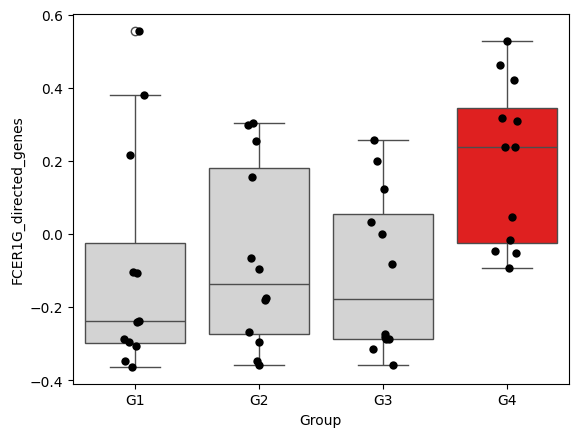

In [3]:

# Merge data to include only the 'Group' column and 'FCER1G_directed_genes'
output = pd.merge(Pla_gene[['Group']], output.T, left_index=True, right_index=True, how='inner')

# Define a custom palette for the 'Group' column
palette = {group: 'red' if group == 'G4' else 'lightgray' for group in output['Group'].unique()}

# Create boxplot and stripplot for visualization
sns.boxplot(x='Group', y="FCER1G_directed_genes", data=output, palette=palette)
sns.stripplot(x='Group', y="FCER1G_directed_genes", data=output, color='black', size=6, jitter=True)

# Display the plot
plt.show()

# Save the plot if needed
#plt.savefig('/home/yang/PM_AD/Submission/Figure_3/Figure3B/Figure_3B.pdf', dpi=300, bbox_inches='tight')


In [4]:
# Perform Wilcoxon rank-sum test between two groups
def wilcox_ranksum_test(tmp1, Case, Control):
    df = tmp1.copy()
    
    # Subset data for Case and Control
    group_Case = df[df['Group'] == Case]
    group_Control = df[df['Group'] == Control]
    
    p_values, t_values = [], []

    # Perform Wilcoxon rank-sum test for each column
    for column in group_Case.columns:
        if column != 'Group':  # Exclude the 'Group' column
            statistic, p_value = ranksums(group_Case[column], group_Control[column])
            p_values.append(p_value)
            t_values.append(statistic)
    
    # Return a DataFrame with p-values and t-values
    return pd.DataFrame({"P": p_values, "T": t_values}, index=group_Case.columns)


In [5]:
# Perform Wilcoxon rank-sum test for different comparisons
wilcox_ranksum_test(output, 'G4', 'G3')

,P,T
Group,0.007912,2.655811
FCER1G_directed_genes,0.007912,2.655811


In [6]:
wilcox_ranksum_test(output, 'G4', 'G2')

,P,T
Group,0.009375,2.598076
FCER1G_directed_genes,0.009375,2.598076


In [7]:
wilcox_ranksum_test(output, 'G4', 'G1')

,P,T
Group,0.007912,2.655811
FCER1G_directed_genes,0.007912,2.655811


### Figure 3C - Linear Regression with Robust Methods

In [8]:
# Load the Clinical data
Cov = pd.read_excel("/home/yang/PM_AD/1_Raw_data/Covariates_data.xlsx", sheet_name="임상정보_")
Cov = Cov.loc[:, ['ID', 'C_cb_Eosiphil']].set_index("ID")

# Merge clinical data with the output data
Clinic_cor = pd.merge(output, Cov, left_index=True, right_index=True, how='inner')


In [9]:
# Extract the relevant columns for regression analysis
x = Clinic_cor["FCER1G_directed_genes"]
y = Clinic_cor["C_cb_Eosiphil"]

# Remove NaN values for both variables
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices].values.reshape(-1, 1)
y = y[valid_indices]

# Fit a robust linear model using Huber T norm
rlm_model = sm.RLM(y, sm.add_constant(x), M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()

# Display results of the regression model
print(f"p-value: {rlm_results.pvalues[1]}")
print(rlm_results.summary())


p-value: 0.04231232055125665
                    Robust linear Model Regression Results                    
Dep. Variable:          C_cb_Eosiphil   No. Observations:                   29
Model:                            RLM   Df Residuals:                       27
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 03 Feb 2025                                         
Time:                        15:23:16                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6983  

/tmp/ipykernel_4112477/3591611249.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"p-value: {rlm_results.pvalues[1]}")


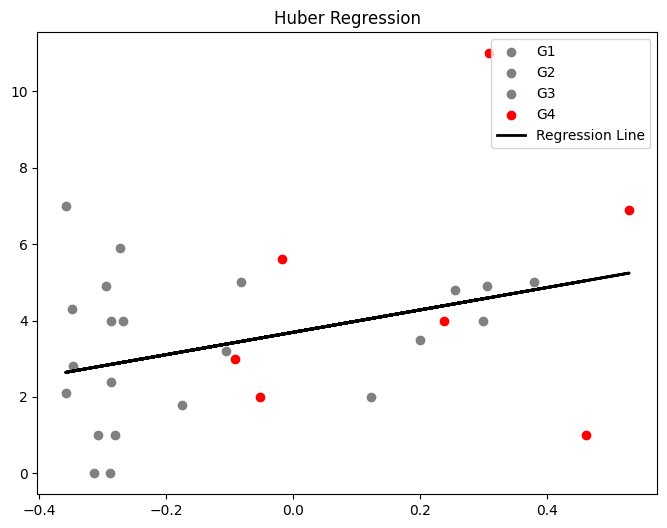

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor

# Set matplotlib figure size and font type for saving as PDF
plt.rcParams["figure.figsize"] = (8, 6)  # Set figure size
plt.rcParams['pdf.fonttype'] = 42  # Set font type to allow editing in PDF

# Select the necessary columns from the Clinic_cor DataFrame
x = Clinic_cor['FCER1G_directed_genes']
y = Clinic_cor['C_cb_Eosiphil']
groups = Clinic_cor['Group']  # Extract the 'Group' column

# Remove NaN values from x, y, and groups
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices].values.reshape(-1, 1)
y = y[valid_indices]
groups = groups[valid_indices]

# Create HuberRegressor model and fit it
model = HuberRegressor()
model.fit(x, y)

# Define group labels and assign colors for each group
group_labels = groups.unique()
colors = ['grey', 'grey', 'grey', 'red']  # Color mapping for groups (default grey, G4 in red)

# Scatter plot for each group
for i, group_label in enumerate(group_labels):
    group_x = x[groups == group_label]
    group_y = y[groups == group_label]
    plt.scatter(group_x, group_y, color=colors[i], label=group_label)

# Plot the regression line
plt.plot(x, model.predict(x), color='black', linewidth=2, label='Regression Line')

# Add title and legend to the plot
plt.title('Huber Regression')
plt.legend()

# Display the plot
plt.show()
